# Прогнозирование уровня средней заработной платы в России

Для выполнения этого задания нам понадобятся данные о среднемесячных уровнях заработной платы в России. Эти данные с января 1993 по июль 2022 записаны в файле WAG_C_M.csv. 

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на три года вперёд от конца данных.

### Загрузка данных

In [1]:
#загружаем необходимые модули
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

#обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
#загружаем данные из файла
data = pd.read_csv('/content/drive/MyDrive/data/WAG_C_M.csv', sep = ',', index_col=['month'], parse_dates=['month'], dayfirst=True, encoding="ISO-8859-1")
data.rename(columns={'WAG_C_M':'wage'}, inplace=True)
print(data.shape)
data.head()

(355, 1)


,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Выведем данные на график:

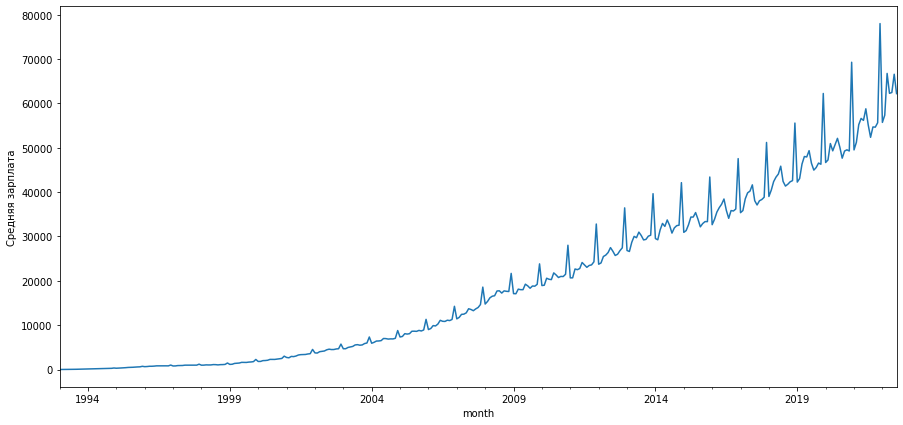

In [3]:
plt.figure(figsize=(15,7))
data.wage.plot()
plt.ylabel(u'Средняя зарплата')
plt.show()

Проверим стационарность ряда с помощью критерия Дики-Фуллера и сделаем также  STL-декомпозицию ряда, которая выделит в нем тренд и сезонную составляющую.

Критерий Дики-Фуллера: p=0.999078


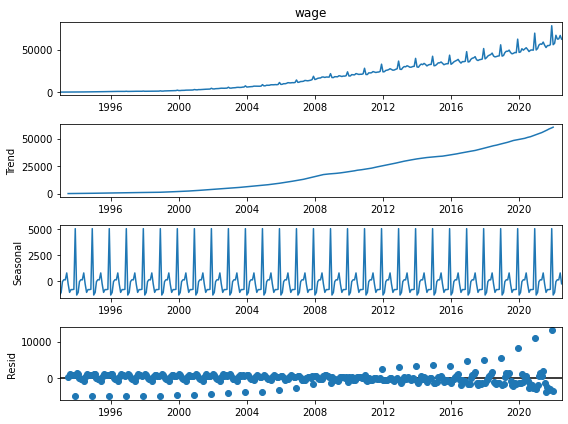

In [4]:
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

sm.tsa.seasonal_decompose(data.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage)[1])

По критерию Дики-Фуллера гипотеза о нестационарности ряда не отвергается. Значение 0.99 больше порога 0.05.

Сразу видны следующие особенности данных:
* возрастающий тренд
* растущая со временем дисперсия
* периодичность (период - 12 месяцев)
* заметная структура остатков

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.297552
Критерий Дики-Фуллера: p=0.849391


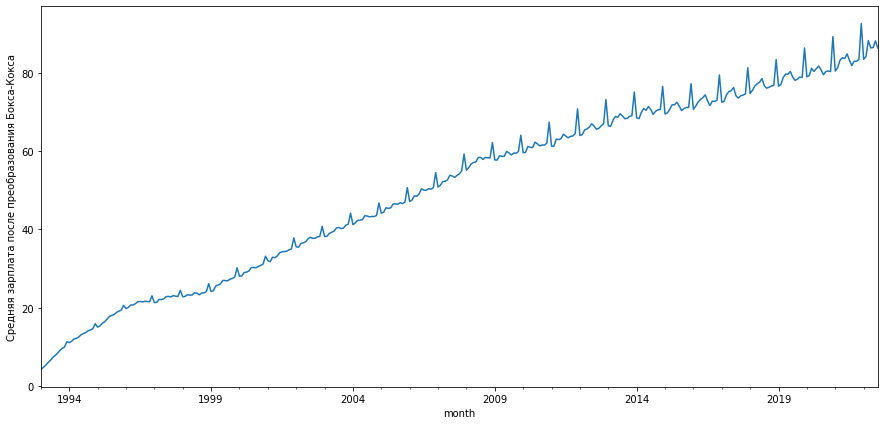

In [5]:
data['wage_box'], lmbda = stats.boxcox(data.wage)
plt.figure(figsize=(15,7))
data.wage_box.plot()
plt.ylabel(u'Средняя зарплата после преобразования Бокса-Кокса')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

Размах дисперсии ощутимо уменьшился.

По критерию Дики-Фуллера нулевая гипотеза о нестационарности ряда не отвергается (0.84 > 0.05)

### Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.018022


<Figure size 1080x720 with 0 Axes>

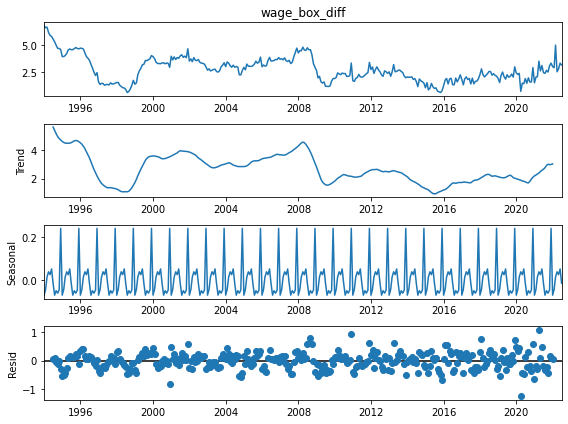

In [6]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1])

По критерию Дики-Фуллера можно отвергнеть гипотезу нестационарности (0.018 < 0.05), в остатках стало заметно меньше структуры, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.001908


<Figure size 1080x720 with 0 Axes>

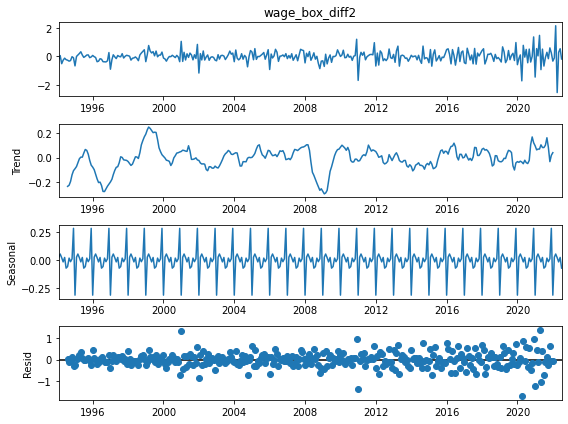

In [7]:
data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, остатки выглядят похоже на белый шум, и явного тренда больше нет. 

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

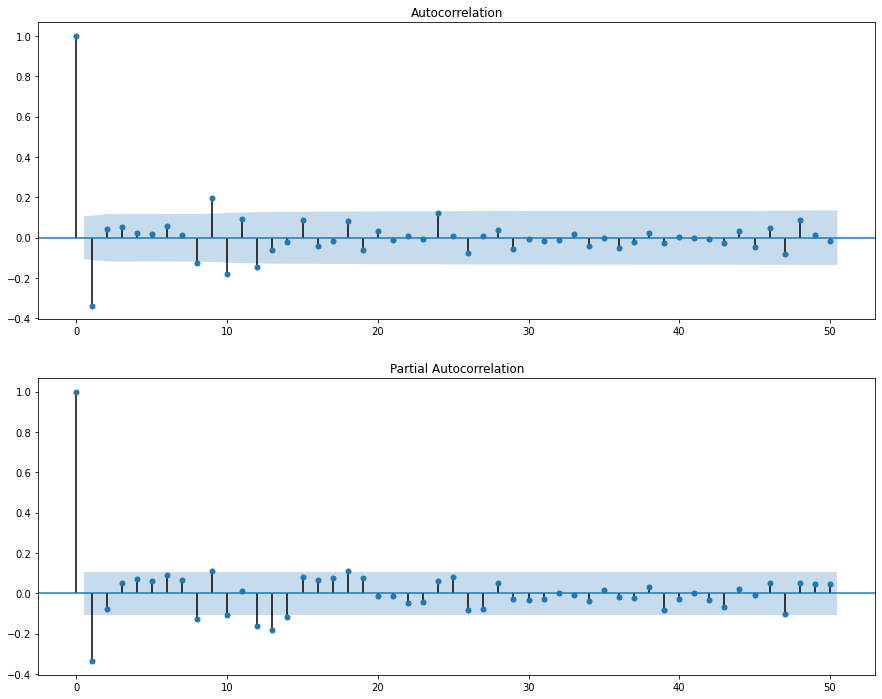

In [8]:
plt.figure(figsize=(15,12))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
plt.show()

Выбираем параметры нашей модели:

__Q__ - значение последнего значимого сезонного лага на автокоррелограмме ACF. Т.к. значимый лаг, кратный периоду (12) один, то __Q = 1__

__q__ - значение последнего значимого несезонного лага на автокоррелограмме, меньшего величин периода __q = 10__

__P__ - значение последнего значимого сезонного лага на частичной автокоррелограмме PACF. В данном случае это лаг = 12, поэтому возьмем значение __P = 1__

__p__ - значение последнего значимого несезонного лага, меньшего величин периода, на частичной автокоррелограмме. __p = 10__


Начальные приближения: Q=1, q=10, P=1, p=10

In [9]:
#устанавливаем значения параметров
p = 10
d=1 # столько раз делали дифференциорование
q = 10
P = 1
D=1 # столько раз делали сезонное дифференцирование
Q = 1

In [10]:
model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit(disp=-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Рассмотрим остатки модели:

Критерий Дики-Фуллера: p=0.000000


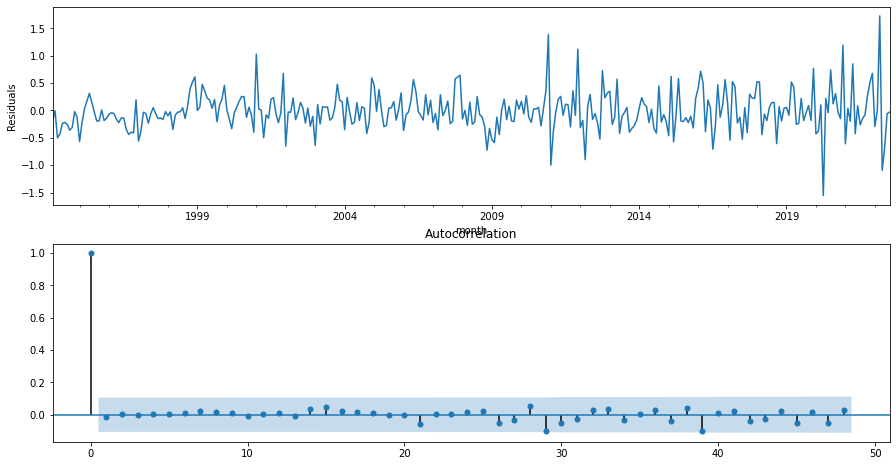

In [11]:
plt.figure(figsize=(15,8))
plt.subplot(211)
model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

Неплохо. Но возможно, стоит перебрать больше значений параметров для поиска оптимальной модели? Обычно после примерного определения значений параметров модели, проводят grid search по наборам близких к оптимальным значений.

In [12]:
#устанавливаем границы массивов наших параметров 
ps = range(10, 12)
d=1
qs = range(10, 12)
Ps = range(0, 2)
D=1
Qs = range(1, 2)

# столько комбинаций параметров будем перебирать
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

Следующий код выполняется долго, т.к. обучает много моделей. Лучшую из них мы будем выбирать на основе критерия Акаике. Чем меньше значение aic, тем лучше.

In [13]:
# для визуализации progress_bar
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [14]:
%%time
prog_bar = display(progress(0, len(parameters_list)), display_id=True) # для визуализации progress bar

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

ii=0 # для prog_bar

for param in parameters_list:
    ii=ii+1
    prog_bar.update(progress(ii, len(parameters_list)))

    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
   
warnings.filterwarnings('default')

CPU times: user 2min 13s, sys: 1min 48s, total: 4min 1s
Wall time: 2min 5s


Выведем 5 лучших моделей. Первой идет модель с наименьшим aic. Как мы видим, это оказалась модель с параметрами (10, 10, 1, 1), которые мы и выбрали изначально. У нас улучшить их значения не получилось, но то, что мы проделали часто помогает найти более удачную модель.

In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
1  (10, 10, 1, 1)  311.444897
5  (11, 10, 1, 1)  317.923366
3  (10, 11, 1, 1)  319.148044
0  (10, 10, 0, 1)  319.853946
4  (11, 10, 0, 1)  320.680200


In [16]:
# полное описание модели
print(best_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                               wage_box   No. Observations:                  355
Model:             SARIMAX(10, 1, 10)x(1, 1, [1], 12)   Log Likelihood                -132.722
Date:                                Mon, 31 Oct 2022   AIC                            311.445
Time:                                        06:12:44   BIC                            399.646
Sample:                                    01-01-1993   HQIC                           346.582
                                         - 07-01-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0607      0.643      0.094      0.925      -1.199       1.321
ar.

Теперь посмотрим, как модель приближает данные.

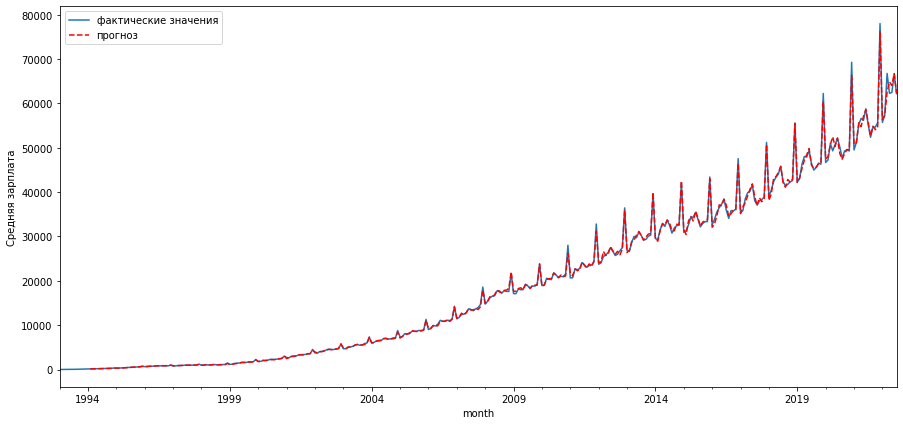

In [17]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
data.wage.plot(label = 'фактические значения')
data.model[13:].plot(color='r', label = 'прогноз', linestyle = '--')
plt.ylabel(u'Средняя зарплата')
plt.legend()
plt.show()

Визуально наша модель неплохо приближает реальные данные. Посмотрим прогноз.

### Прогноз

Прежде всего посмотрим, как модель прогнозирует те данные, которые мы знаем. Разделим набор данных на обучающий и тестовый.

In [18]:
# обучающая выборка будет включать данные до декабря 2020 года включительно
train = data[:'2020-12-01']
# тестовая выборка начнется с января 2021 года
test = data['2021-01-01':]

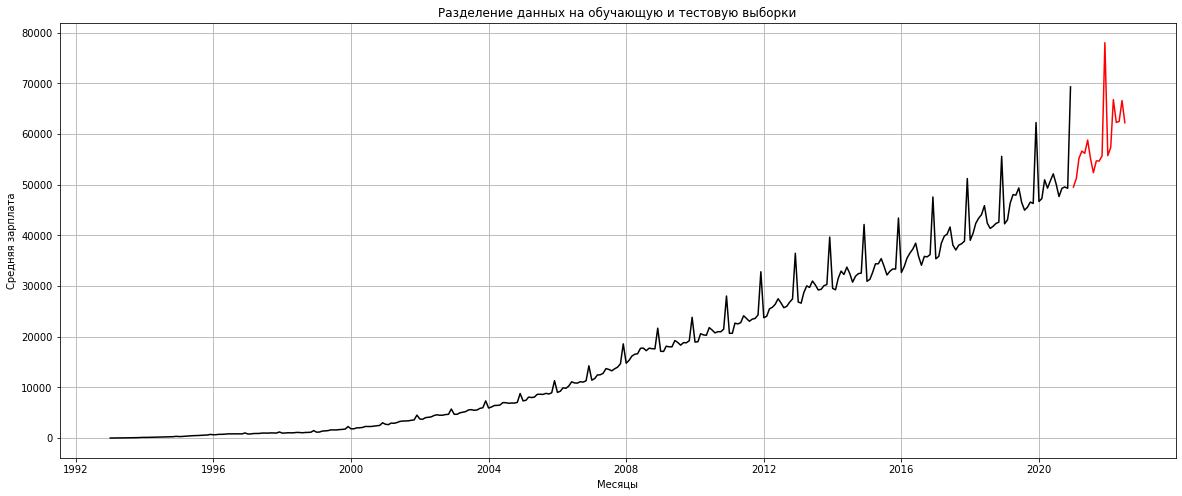

In [19]:
# Посмотрим на разделение на графике
plt.figure(figsize=(20,8))
plt.plot(train['wage'], color = "black")
plt.plot(test['wage'], color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('Средняя зарплата')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

In [20]:
#устанавливаем значения параметров
p = 10
d = 1 # столько раз делали дифференциорование
q = 10
P = 1
D = 1 # столько раз делали сезонное дифференцирование
Q = 1

In [21]:
# Обучаем модель на train
model_1=sm.tsa.statespace.SARIMAX(train.wage_box, order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit(disp=-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [22]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict и обратное преобразование Бокса-Кокса
predictions = invboxcox(model_1.predict(start, end), lmbda)
predictions

2021-01-01    51741.487971
2021-02-01    53409.364257
2021-03-01    57674.119416
2021-04-01    56600.052347
2021-05-01    58398.696963
2021-06-01    59890.155222
2021-07-01    57739.503359
2021-08-01    54937.373315
2021-09-01    56380.027858
2021-10-01    56762.710824
2021-11-01    56211.854640
2021-12-01    77292.617241
2022-01-01    58134.678827
2022-02-01    59533.895443
2022-03-01    64034.603340
2022-04-01    62734.234306
2022-05-01    64758.402740
2022-06-01    66753.173936
2022-07-01    64852.348801
Freq: MS, Name: predicted_mean, dtype: float64

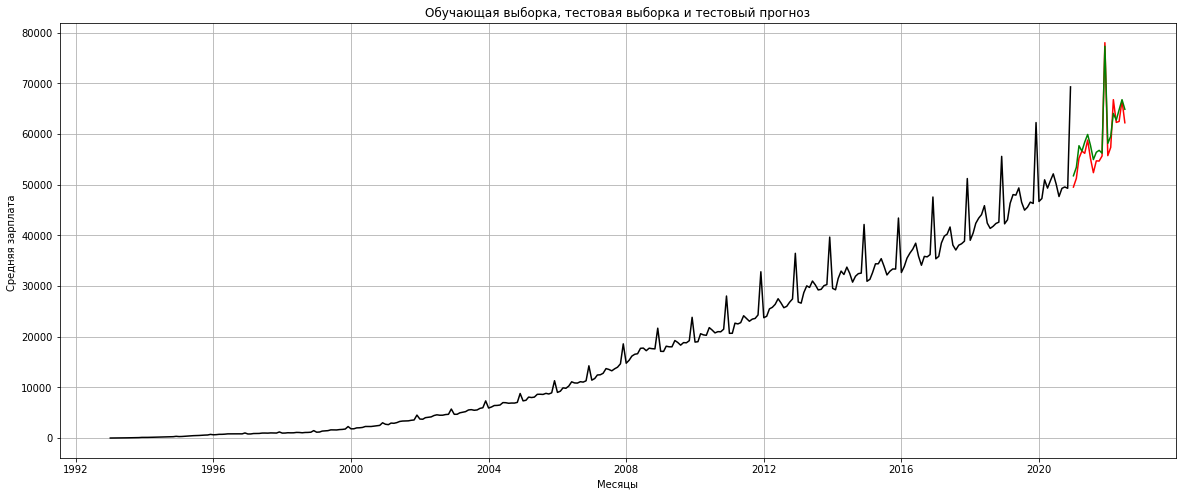

In [23]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(20,8))
plt.plot(train['wage'], color = "black")
plt.plot(test['wage'], color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Средняя зарплата ')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

В целом модель хорошо описывает временной ряд. Мы также можем использовать  метрики среднеквадратической ошибки (MSE) и корня среднеквадратической ошибки (RMSE) для оценки качества.

In [24]:
# импортируем метрику
from sklearn.metrics import mean_squared_error
 
# рассчитаем MSE
print(mean_squared_error(test['wage'], predictions))
 
# и RMSE
print(np.sqrt(mean_squared_error(test['wage'], predictions)))

3896711.3120288537
1974.0089442626277


В среднем ошибаемся примерно на 2000 рублей.

Теперь можно делать прогноз на будущее. Возьмём горизонт равный трем годам. Всего должно получиться 36 прогнозных значений.

In [25]:
# прогнозный период с конца имеющихся данных
start = len(data)
 
# и закончится 36 месяцев спустя
end = (len(data) - 1) + 3 * 12
 
# теперь построим прогноз на три года вперед
forecast = invboxcox(best_model.predict(start, end), lmbda)
forecast

2022-08-01     59378.921597
2022-09-01     62505.209848
2022-10-01     61251.814794
2022-11-01     61949.011299
2022-12-01     87684.774996
2023-01-01     61166.243861
2023-02-01     63444.892220
2023-03-01     73196.995765
2023-04-01     69204.988995
2023-05-01     69252.132161
2023-06-01     74584.878817
2023-07-01     68757.639779
2023-08-01     65943.739179
2023-09-01     70022.416461
2023-10-01     67859.185847
2023-11-01     69271.208597
2023-12-01     97596.693426
2024-01-01     68637.141250
2024-02-01     71099.306024
2024-03-01     82875.397397
2024-04-01     75989.509135
2024-05-01     76699.775005
2024-06-01     83141.709071
2024-07-01     76353.207500
2024-08-01     73415.226964
2024-09-01     78330.181889
2024-10-01     75136.382242
2024-11-01     76544.631933
2024-12-01    107790.757036
2025-01-01     75635.915021
2025-02-01     78511.998319
2025-03-01     90993.499740
2025-04-01     84486.962129
2025-05-01     84876.013030
2025-06-01     92298.741604
2025-07-01     84287

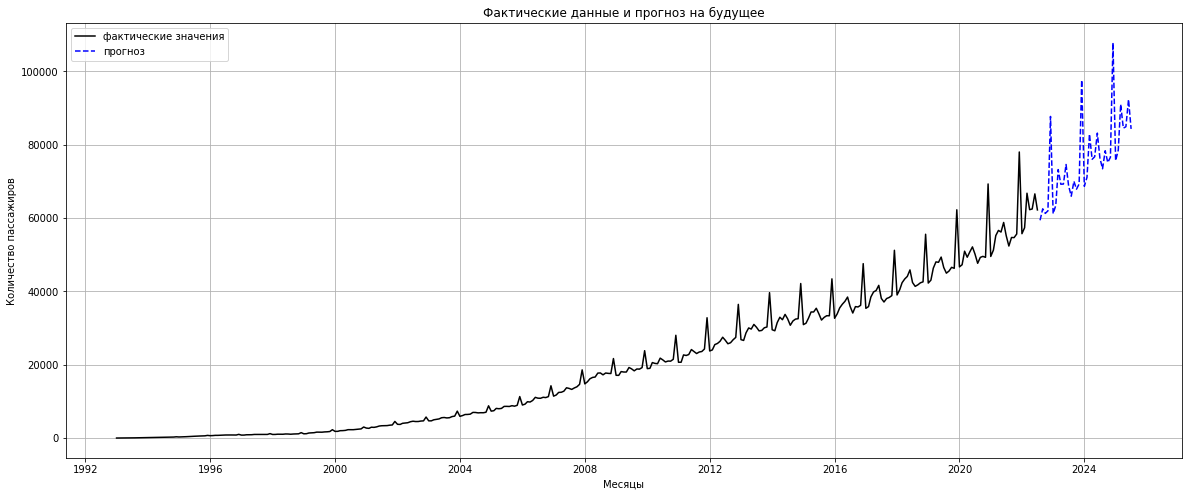

In [26]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.figure(figsize=(20,8))
plt.plot(data.wage, color = 'black', label = 'фактические значения')
plt.plot(forecast, color = 'blue', label = 'прогноз', linestyle = '--')
plt.legend()
 
# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

Видно, что прогноз учитывает как сезонные колебания в данных, так и возрастающий тренд. Прогноз выглядит адекватно.